In [ ]:
import numpy as np
x_transformed = pca.transform(x)
print(pca.explained_variance_ / np.sum(pca.explained_variance_))

import seaborn as sns
sns.scatterplot(x=x_transformed[:, 0], y=x_transformed[:,1], hue=df["status"])

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import dump, load
import os

class GridSearch:
    def __init__(self, clf, params) -> None:
        self.clf = clf
        self.params = params
        self.grid = GridSearchCV(estimator=self.clf, param_grid=self.params, return_train_score=True, verbose=1,n_jobs=-1)
    
    def train(self,x_train, y_train):
        self.grid.fit(x_train, y_train)

    def plot_selection_process(self, save=None, path=None):
        ## Results from grid search
        results = self.grid.cv_results_
        means_test = results['mean_test_score']
        stds_test = results['std_test_score']
        means_train = results['mean_train_score']
        stds_train = results['std_train_score']
        ## Getting indexes of values per hyper-parameter
        masks=[]
        masks_names= list(self.grid.best_params_.keys())
        for p_k, p_v in self.grid.best_params_.items():
            masks.append(list(results['param_'+p_k].data==p_v))

        params=self.grid.param_grid

        ## Ploting results
        fig, ax = plt.subplots(1,len(params),sharex='none', sharey='none',figsize=(20,5))
        fig.suptitle( str(self.clf)[:-2] + ': Score per parameter')
        fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
        pram_preformace_in_best = {}
        for i, p in enumerate(masks_names):
            m = np.stack(masks[:i] + masks[i+1:])
            pram_preformace_in_best
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            y_2 = np.array(means_train[best_index])
            e_2 = np.array(stds_train[best_index])
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
            ax[i].set_xlabel(p.upper())

        plt.legend()
        plt.show()
        if save:
            fig.savefig(str(path) + "/" + str(self.clf)[:-2] + "_parameter_overview.png")

    def classification_result(self, y_train, y_test):
        # grid.predict() call predict on the estimator with the best found params
        y_pred = self.grid.predict(y_train)
        self.classification_results = classification_report(y_test, y_pred, output_dict=True)
        return self.classification_results

    def plot_classification_result(self, y_train, y_test, save=None, path=None):
        df = pd.DataFrame(self.classification_result(y_train, y_test))
        if save:
            fig = sns.heatmap(df.iloc[:-1, :].T, annot=True).get_figure()
            fig.savefig(str(path) + "/" + str(self.clf)[:-2] + "class_report.png") 
        else: 
            sns.heatmap(df.iloc[:-1, :].T, annot=True)

    def store_best_estimator(self, path):
        dump(self.grid.best_estimator_, path)

def takeSecond(elem):
    return elem[1]
    
def pca_transform(n_components, x):
    pca = PCA(n_components=n_components)
    pca.fit(x)
    return pca.transform(x)

def scaler_transform(x):
    scaler = StandardScaler()
    scaler.fit(x)
    return scaler.transform(x)

estimators = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
estimator_params = [
    {
        "n_neighbors": range(1,5,1),
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "n_jobs": [-1]
    },
    {
        "criterion": ['gini', 'entropy'],
        "max_depth": [6, 10, 12, 15],
        "min_samples_split": range(2,10),
        "min_samples_leaf": range(2,10)
    },
    {
        "n_estimators": [60, 80, 100, 150],
        "criterion": ["log_loss", "gini", "entropy"],
        "max_depth": [6, 10, 12, 15], 
        "min_samples_leaf": [2, 4, 6],
        "min_samples_split": [2, 4, 6]
    }
]

def train_evaluate_estimators_gridsearch(x, y, estimators, estimator_params, scaling=None, pca=None):
    path = ""
    if scaling: 
        print("scaling...")
        x = scaler_transform(x)
        path = path + "scaled_"
    
    if pca:
        print("PCA...")
        path = path + "pca_"
        x = pca_transform(4, x)

    if pca==None and scaling==None:
        path="normal_"

    if not os.path.exists(path):
        os.makedirs(path)

    results = []
    x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2)
    for estimator, estimator_params in zip(estimators, estimator_params):
        store_path = path + str(estimator)[:-2]
        grid = GridSearch(clf=estimator, params=estimator_params)
        print(str(store_path) + " is training...")
        grid.train(x_train,y_train)
        grid.plot_classification_result(x_test,y_test, save=True, path=path)
        grid.plot_selection_process(save=True, path=path)
        result_dict = {
            "scaling": scaling,
            "pca": pca,
            "estimator": str(estimator),
            "best_score": grid.grid.best_score_,
            "best_params": grid.grid.best_params_
        }
        results.append(result_dict)
        grid.store_best_estimator(path + "/" + store_path + ".joblib")
    return results

In [5]:
df = pd.read_csv("../static_merged_data.csv")
x = df.drop("status", axis=1)
y = df["status"]

In [4]:
def evaluation_process(estimators, estimator_params):
    pca_scale_results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params,True,True)
    with open('results.txt', 'a') as f:
        f.write("\n\n")
        f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
        sorted_list = []
        for params in pca_scale_results:
            f.write(str(params))
            f.write("\n\n")
            sorted_list.append((params["estimator"], params["best_score"]))
        
        sorted_list.sort(key=takeSecond)
        f.write("----- Best estimator-----\n")
        for idx,element in enumerate(sorted_list):
            print(str(idx+1) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")

    pca_results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params, pca=True)
    with open('results.txt', 'a') as f:
        f.write("\n\n")
        f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
        sorted_list = []
        for params in pca_results:
            f.write(str(params))
            f.write("\n\n")
            sorted_list.append((params["estimator"], params["best_score"]))
        
        sorted_list.sort(key=takeSecond)
        f.write("----- Best estimator-----\n")
        for idx,element in enumerate(sorted_list):
            print(str(idx+1) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")

    scale_results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params,scaling=True)
    with open('results.txt', 'a') as f:
        f.write("\n\n")
        f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
        sorted_list = []
        for params in scale_results:
            f.write(str(params))
            f.write("\n\n")
            sorted_list.append((params["estimator"], params["best_score"]))
        
        sorted_list.sort(key=takeSecond)
        f.write("----- Best estimator-----\n")
        for idx,element in enumerate(sorted_list):
            print(str(idx+1) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")

    results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params)
    with open('results.txt', 'a') as f:
        f.write("\n\n")
        f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
        sorted_list = []
        for params in results:
            f.write(str(params))
            f.write("\n\n")
            sorted_list.append((params["estimator"], params["best_score"]))
        
        sorted_list.sort(key=takeSecond)
        f.write("----- Best estimator-----\n")
        for idx,element in enumerate(sorted_list):
            f.write(str(3-idx) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")


normal_KNeighborsClassifier is training...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


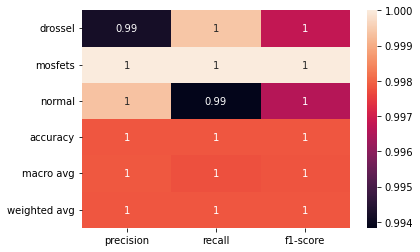

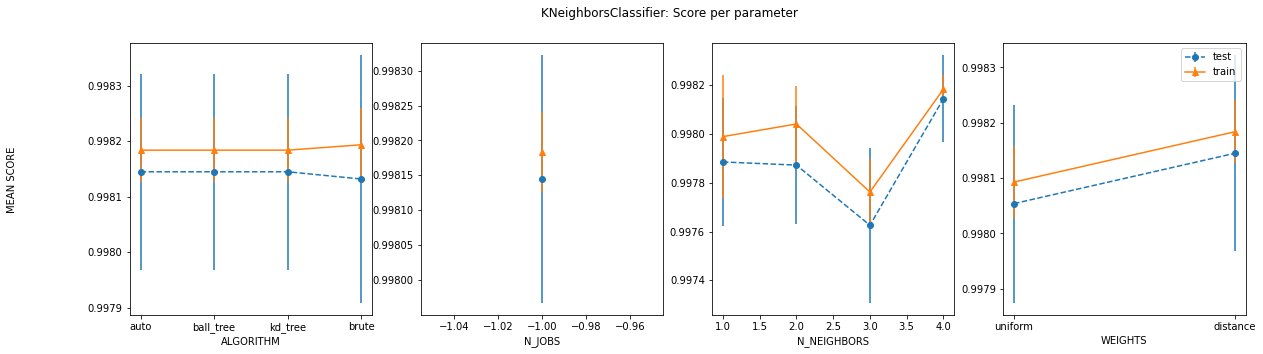

normal_DecisionTreeClassifier is training...
Fitting 5 folds for each of 512 candidates, totalling 2560 fits


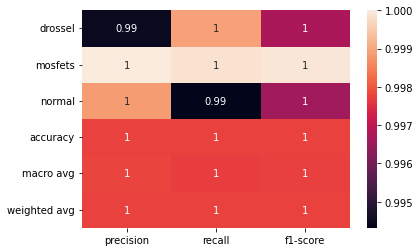

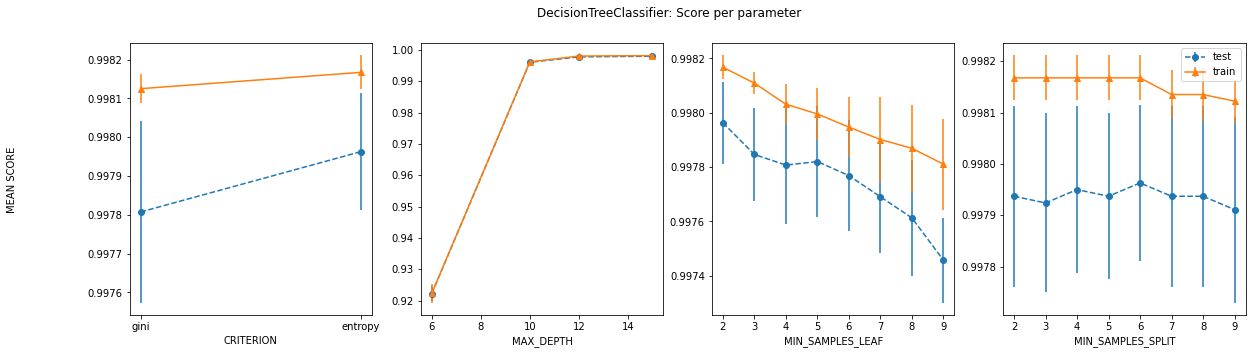

normal_RandomForestClassifier is training...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


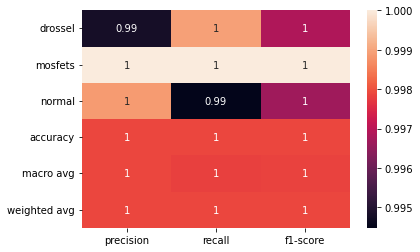

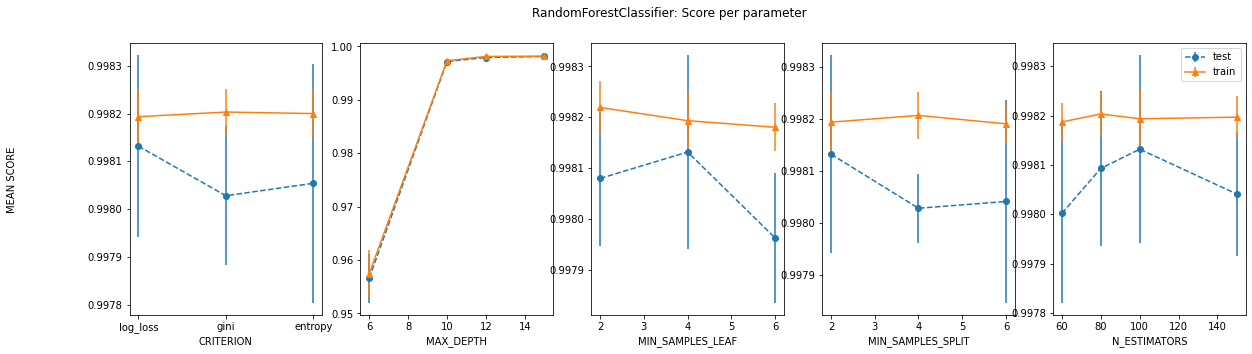

In [6]:
results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params)
with open('results.txt', 'a') as f:
    f.write("\n\n")
    f.write("NORMAL")
    f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
    sorted_list = []
    for params in results:
        f.write(str(params))
        f.write("\n\n")
        sorted_list.append((params["estimator"], params["best_score"]))
    
    sorted_list.sort(key=takeSecond)
    f.write("----- Best estimator-----\n")
    for idx,element in enumerate(sorted_list):
        f.write(str(3-idx) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")

scaling...
PCA...
scaled_pca_KNeighborsClassifier is training...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


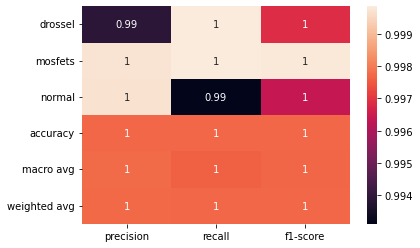

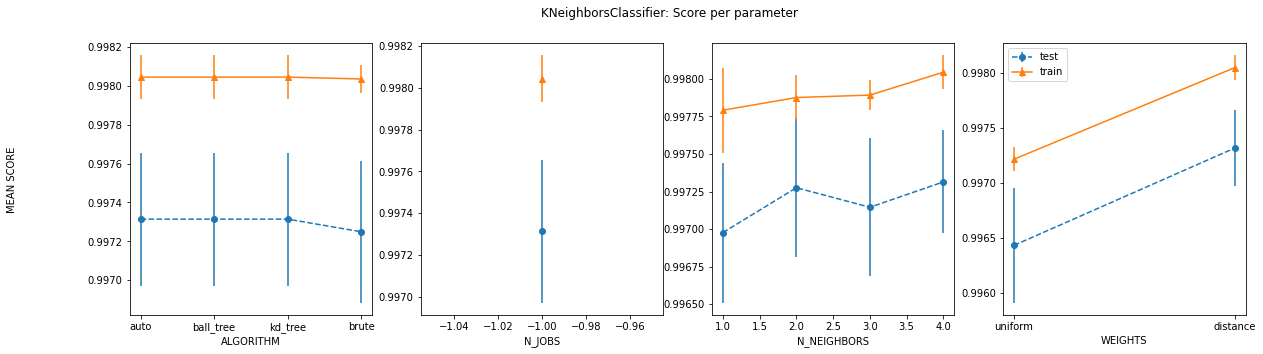

scaled_pca_DecisionTreeClassifier is training...
Fitting 5 folds for each of 512 candidates, totalling 2560 fits


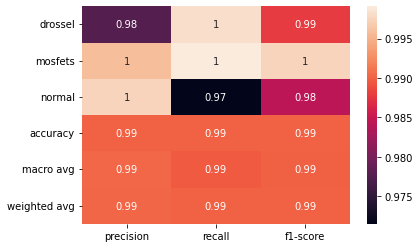

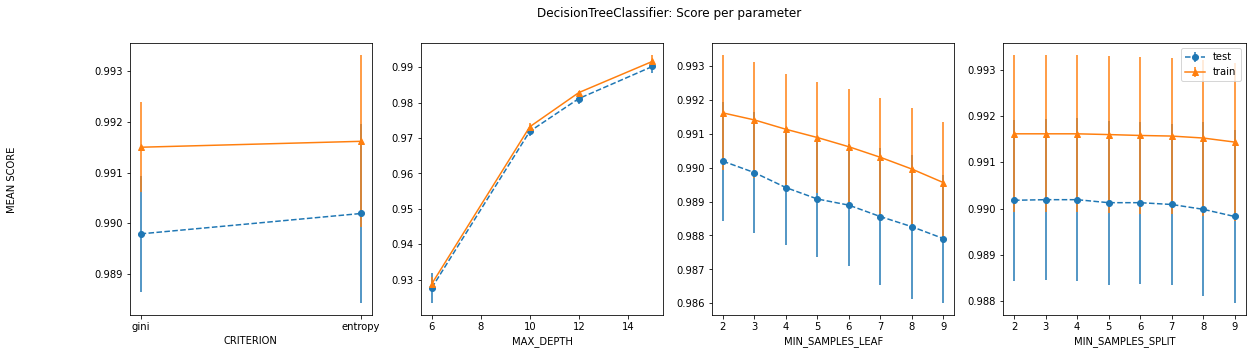

scaled_pca_RandomForestClassifier is training...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


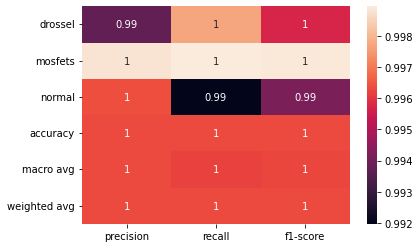

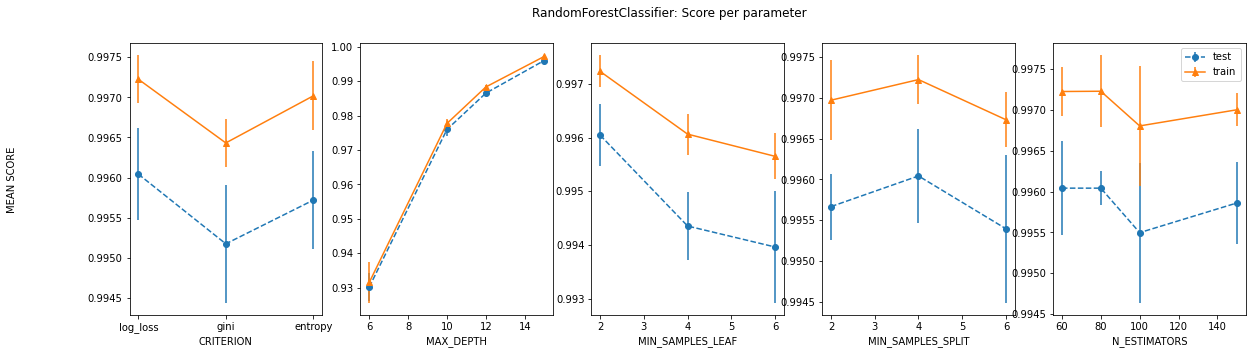

1. DecisionTreeClassifier()-> accuracy: 99.01919005760199%

2. RandomForestClassifier()-> accuracy: 99.60430241606505%

3. KNeighborsClassifier()-> accuracy: 99.73144456408505%

PCA...
pca_KNeighborsClassifier is training...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


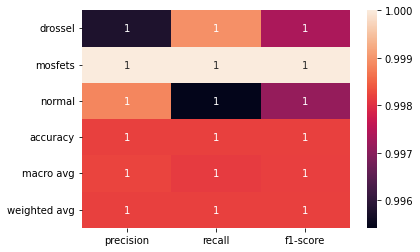

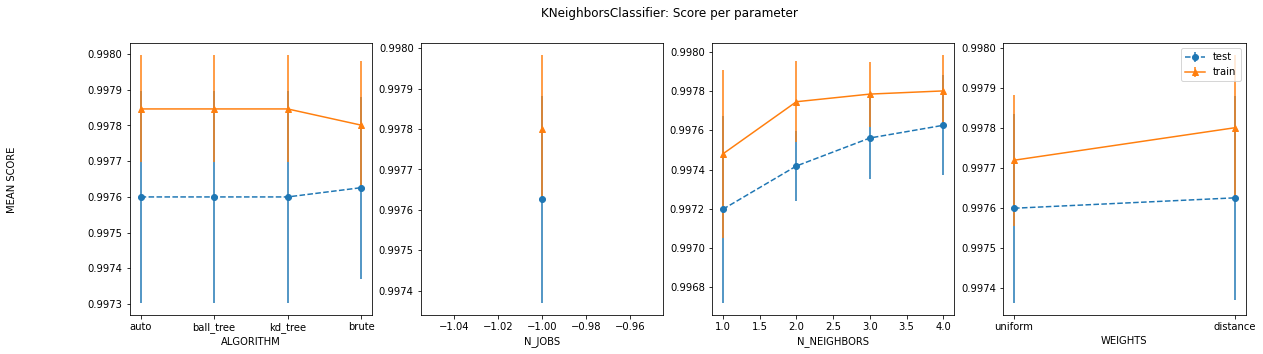

pca_DecisionTreeClassifier is training...
Fitting 5 folds for each of 512 candidates, totalling 2560 fits


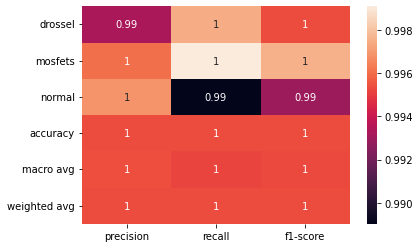

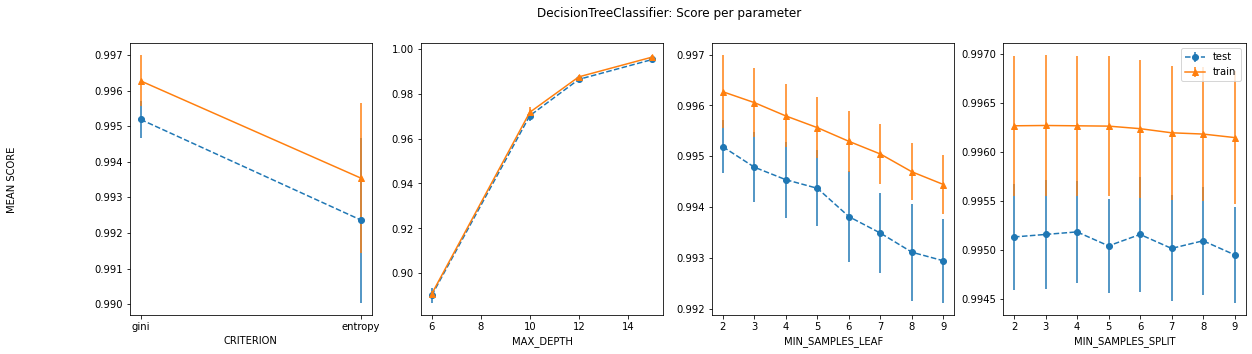

pca_RandomForestClassifier is training...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


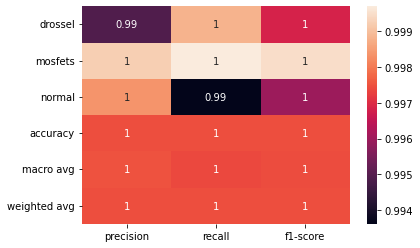

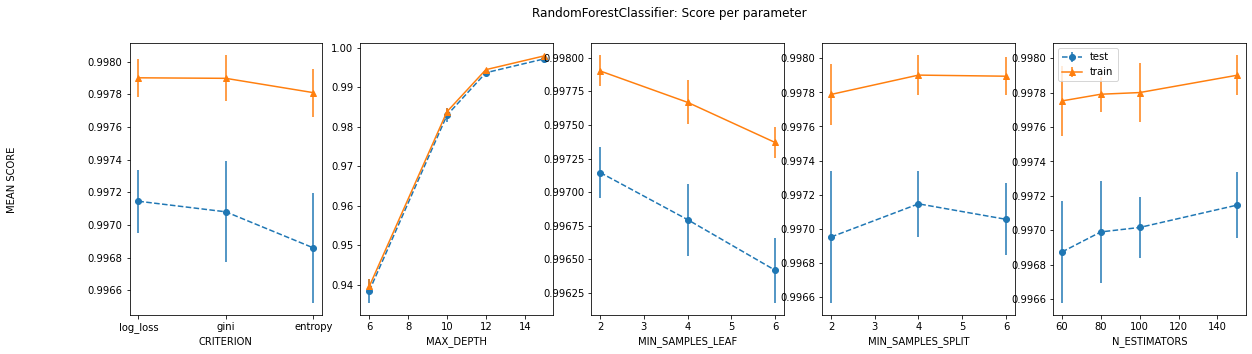

1. DecisionTreeClassifier()-> accuracy: 99.51867599762394%

2. RandomForestClassifier()-> accuracy: 99.71457846492669%

3. KNeighborsClassifier()-> accuracy: 99.76258138230965%

scaling...
scaled_KNeighborsClassifier is training...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


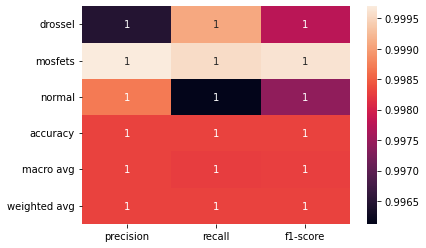

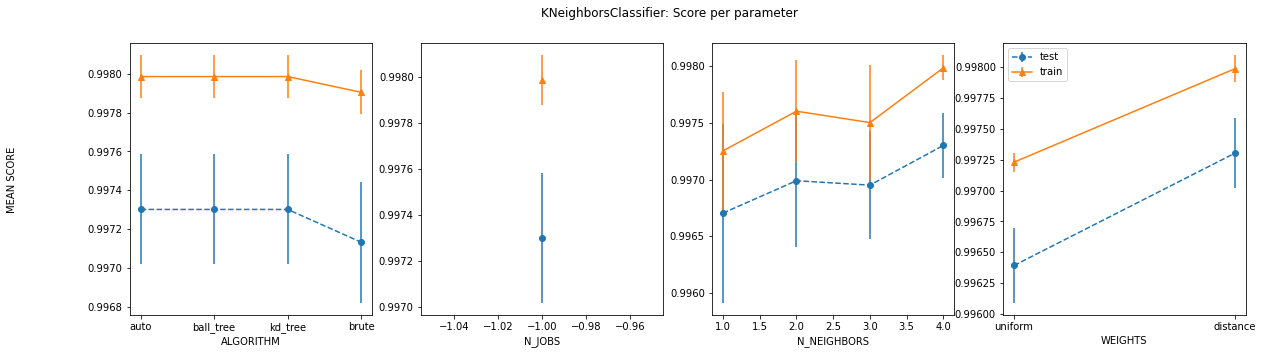

scaled_DecisionTreeClassifier is training...
Fitting 5 folds for each of 512 candidates, totalling 2560 fits


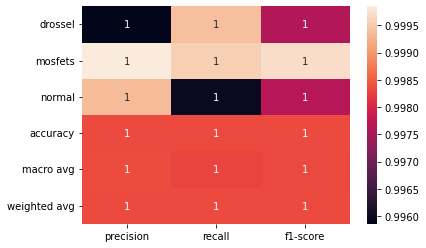

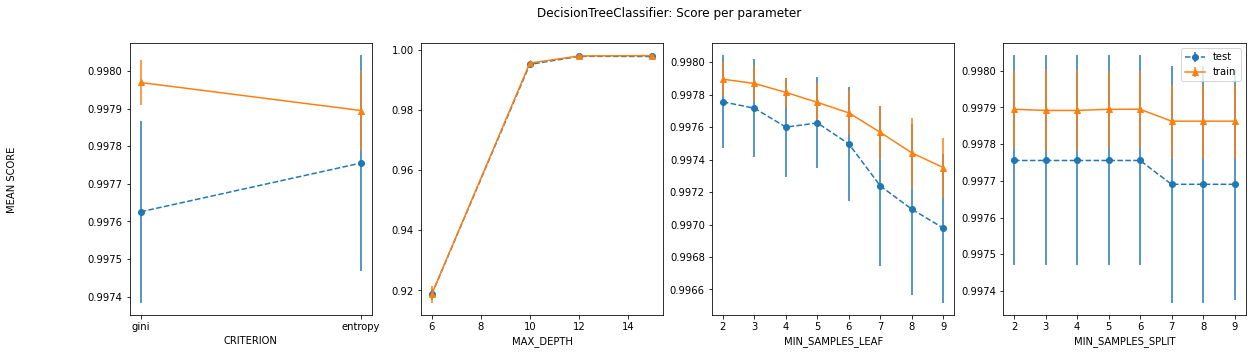

scaled_RandomForestClassifier is training...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


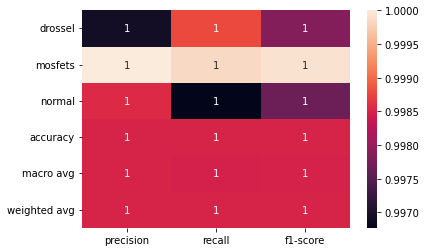

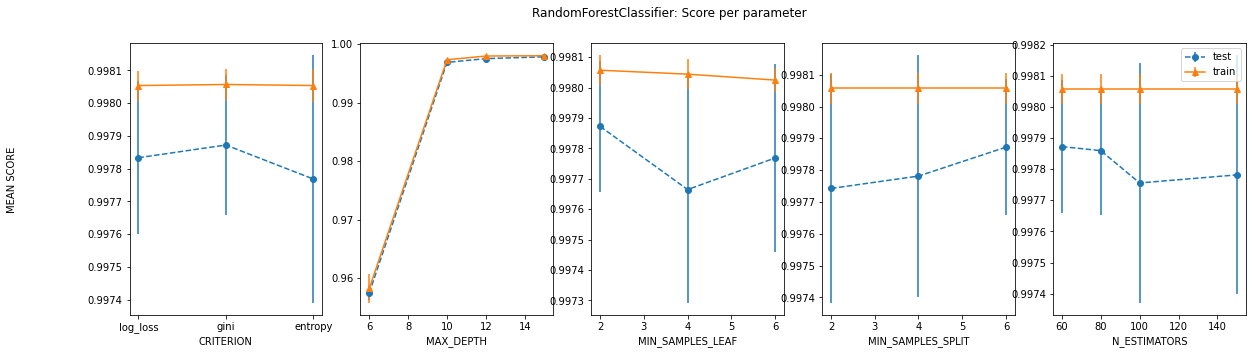

1. KNeighborsClassifier()-> accuracy: 99.73014670571547%

2. DecisionTreeClassifier()-> accuracy: 99.77555525294729%

3. RandomForestClassifier()-> accuracy: 99.78723151770063%



FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: ''

In [5]:
evaluation_process(estimators, estimator_params)

In [6]:
from joblib import load

dt = load(filename="./scaled_/scaled_DecisionTreeClassifier.joblib")